In [77]:
import os
import random
from torch.utils.data import random_split, Dataset, DataLoader, Subset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm
from collections import defaultdict
import cv2
import pandas as pd
import segmentation_models_pytorch as smp
import numpy as np
import pickle
%matplotlib inline

In [3]:
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io import read_image

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Data Curation

### Flower Classification Data -- 17 Categories, 1360 Images total

In [4]:
datadir = './data/jpg/'
maskdir = './data/trimaps/'

classes = {
    "daffodil": range(1, 81),
    "snowdrop": range(81, 161),
    "lilyvalley": range(161, 241),
    "bluebell": range(241, 321),
    "crocus": range(321, 401),
    "iris": range(401, 481),
    "tigerlily": range(481, 561),
    "tulip": range(561, 641),
    "fritillary": range(641, 721),
    "sunflower": range(721, 801),
    "daisy": range(801, 881),
    "coltsfoot": range(881, 961),
    "dandelion": range(961, 1041),
    "cowslip": range(1041, 1121),
    "buttercup": range(1121, 1201),
    "windflower": range(1201, 1281),
    "pansy": range(1281, 1361),
}

In [5]:
for classs, indices in classes.items():
    for idx in indices:
        old_img = f"image_{str(idx).zfill(4)}.jpg"
        old_img_mask = f"image_{str(idx).zfill(4)}.png"

        new_img = f"{classs}_{str(idx).zfill(4)}.jpg"
        new_img_mask = f"{classs}_{str(idx).zfill(4)}.png"

        old_path = os.path.join(datadir, old_img)
        old_path_mask = os.path.join(maskdir, old_img_mask)

        new_path = os.path.join(datadir, new_img)
        new_path_mask = os.path.join(maskdir, new_img_mask)

        if os.path.exists(old_path):
            os.rename(old_path, new_path)

        if os.path.exists(old_path_mask):
            os.rename(old_path_mask, new_path_mask)

In [6]:
data_images = [f for f in os.listdir(datadir)]
mask_images = [f for f in os.listdir(maskdir)]

In [7]:
random.seed(42)
daffodils = [f for f in os.listdir(datadir) if 'daffodil' in f]
snowdrop = [f for f in os.listdir(datadir) if 'snowdrop' in f]
lilyvalley = [f for f in os.listdir(datadir) if 'lilyvalley' in f]
bluebell = [f for f in os.listdir(datadir) if 'bluebell' in f]
crocus = [f for f in os.listdir(datadir) if 'crocus' in f]
iris = [f for f in os.listdir(datadir) if 'iris' in f]
tigerlily = [f for f in os.listdir(datadir) if 'tigerlily' in f]
tulip = [f for f in os.listdir(datadir) if 'tulip' in f]
fritillary = [f for f in os.listdir(datadir) if 'fritillary' in f]
sunflower = [f for f in os.listdir(datadir) if 'sunflower' in f]
daisy = [f for f in os.listdir(datadir) if 'daisy' in f]
coltsfoot = [f for f in os.listdir(datadir) if 'coltsfoot' in f]
dandelion = [f for f in os.listdir(datadir) if 'dandelion' in f]
cowslip = [f for f in os.listdir(datadir) if 'cowslip' in f]
buttercup = [f for f in os.listdir(datadir) if 'buttercup' in f]
windflower = [f for f in os.listdir(datadir) if 'windflower' in f]
pansy = [f for f in os.listdir(datadir) if 'pansy' in f]
segmentation_data = [f for f in os.listdir(maskdir)]
random.shuffle(segmentation_data)

In [8]:
datas = {
    0:daffodils,
    1:snowdrop,
    2:lilyvalley,
    3:bluebell,
    4:crocus,
    5:iris,
    6:tigerlily,
    7:tulip,
    8:fritillary,
    9:sunflower,
    10:daisy,
    11:coltsfoot,
    12:dandelion,
    13:cowslip,
    14:buttercup,
    15:windflower,
    16:pansy
}

In [9]:
train_data, val_data, test_data = [], [], []

for classe, data in datas.items():
        train_data += [(file, float(classe)) for file in data[:64]]
        val_data += [(file, float(classe)) for file in data[64:72]]
        test_data += [(file, float(classe)) for file in data[72:80]]

# Shuffling the sets to mix between classes of dogs and cats
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# Saving the lists as data frames
train_df = pd.DataFrame(train_data, columns=['filename', 'label'])
val_df = pd.DataFrame(val_data, columns=['filename', 'label'])
test_df = pd.DataFrame(test_data, columns=['filename', 'label'])

# Converting data frames into csv files
train_df.to_csv('./data/train.csv', index=False)
val_df.to_csv('./data/validation.csv', index=False)
test_df.to_csv('./data/test.csv', index=False)

#######
# This work will help us follow the PyTorch implementation to create a custom dataset class and load
# custom data to be used with the PyTorch framework. Followed from the link below:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
#######

### Segmentation Data -- 849 Images W/ Groundtruth

In [10]:
seg_train_data, seg_val_data, seg_test_data = [], [], []

train_seg, val_seg, test_seg = segmentation_data[:679], segmentation_data[679:764], segmentation_data[764:849]    

In [11]:
for file in train_seg:
    if os.path.exists(os.path.join(datadir, file.split('.')[0]+'.jpg')):
        seg_train_data += [(file, file.split('.')[0]+'.jpg')]
for file in val_seg:
    if os.path.exists(os.path.join(datadir, file.split('.')[0]+'.jpg')):
        seg_val_data += [(file, file.split('.')[0]+'.jpg')]
for file in test_seg:
    if os.path.exists(os.path.join(datadir, file.split('.')[0]+'.jpg')):
        seg_test_data += [(file, file.split('.')[0]+'.jpg')]


random.shuffle(seg_train_data)
random.shuffle(seg_val_data)
random.shuffle(seg_test_data)

# Saving the lists as data frames
seg_train_df = pd.DataFrame(seg_train_data, columns=['filename', 'label'])
seg_val_df = pd.DataFrame(seg_val_data, columns=['filename', 'label'])
seg_test_df = pd.DataFrame(seg_test_data, columns=['filename', 'label'])

# Converting data frames into csv files
seg_train_df.to_csv('./data/seg_train.csv', index=False)
seg_val_df.to_csv('./data/seg_validation.csv', index=False)
seg_test_df.to_csv('./data/seg_test.csv', index=False)

### Creating Datasets

In [73]:
class FlowersDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class SegmentationDataset(Dataset):
    def __init__(self, annotations_file, img_dir, mask_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        mask_path = os.path.join(self.mask_dir, self.img_labels.iloc[idx, 0])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        return image, mask

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [74]:
flower_train = FlowersDataset(annotations_file='./data/train.csv', img_dir=datadir, transform=transform)
flower_val = FlowersDataset(annotations_file='./data/validation.csv', img_dir=datadir, transform=transform)
flower_test = FlowersDataset(annotations_file='./data/test.csv', img_dir=datadir, transform=transform)
flower_test[0][0].shape

torch.Size([3, 224, 224])

In [75]:
seg_train = SegmentationDataset(annotations_file='./data/seg_train.csv', img_dir=datadir, 
                                mask_dir=maskdir, transform=transform, target_transform=target_transform)
seg_val = SegmentationDataset(annotations_file='./data/seg_validation.csv', img_dir=datadir, 
                              mask_dir=maskdir, transform=transform, target_transform=target_transform)
seg_test = SegmentationDataset(annotations_file='./data/seg_test.csv', img_dir=datadir, 
                               mask_dir=maskdir, transform=transform, target_transform=target_transform)
seg_test[0][1].shape

torch.Size([1, 224, 224])

### Visualizing Data

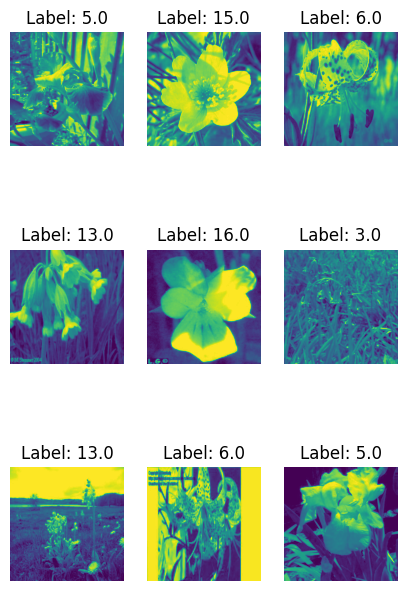

In [16]:
figure = plt.figure(figsize=(5,8))
cols, row = 3, 3
for i in range(1, 10):
    #Grab random index from the train dataset and grab the image tensor and the label
    idx = torch.randint(len(flower_train), size=(1,)).item()
    img, label = flower_train[idx]
    figure.add_subplot(row, cols, i)
    plt.title(f'Label: {label}')
    plt.axis('off')
    # plt function to show an image that we get rid of the channel dimension and output image 
    # with shape (224, 224)
    plt.imshow(img[0])
plt.show()

### Images Along W/ Their Segmentation Ground Truth

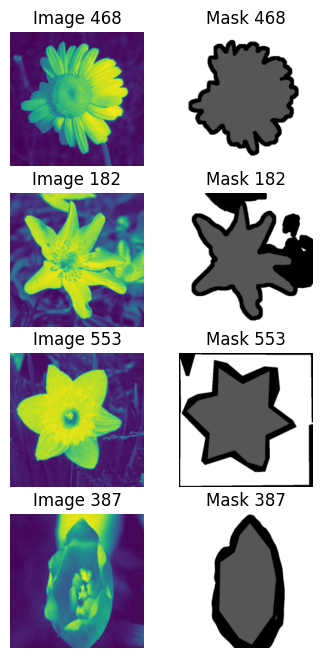

In [15]:
figure = plt.figure(figsize=(4,8))
cols, row = 2, 4
for i in range(1, 5):
    #Grab random index from the train dataset and grab the image tensor and the label
    idx = torch.randint(len(seg_train), size=(1,)).item()
    img, label = seg_train[idx]
    # Plot the image
    figure.add_subplot(4, 2, 2 * i - 1)
    plt.axis('off')
    plt.title(f"Image {idx}")
    plt.imshow(img[0])

    # Plot the mask
    figure.add_subplot(4, 2, 2 * i)
    plt.axis('off')
    plt.title(f"Mask {idx}")
    plt.imshow(label[0], cmap='gray') 
plt.show()

### Helper Functions

In [15]:
# Helper function to train each of the models that we will create
# takes
def seg_train_model(model, epochs, train_set, val_set, batch_size, best_model_name, device, lr=0.01):
    """
    Helper function to train each of the three models that we will create
    
    Parameters:
        model: PyTorch model that will be trained
        epochs: number of epochs that we will train our model for, # of passes through the data
        train_set: the training set we will use
        val_set: the validation set we will use
        batch_size: size of our mini-batches for our dataloaders
        best_model_name: name of our best model we will save
        lr: learning rate for our optimizer
    
    Returns:
        log: dictionary of train losses, val losses, and val accuracies
    
    """
    print('Using:',device)
    log = defaultdict(list)
    
    #variable for the minimum validation loss we saw to save the best model parameters from our training
    min_val_loss = float('inf')
    
    #Create train_loader and val_loader DataLoaders that will help us work through batches in our training, validation,
    # and testing. The DataLoader is used from torch as a way to get mini-batches of size batch_size
    # We shuffle the data in training to promote randomnness but don't do so for validation or testing
    # drop_last drops the last batch from anything if its size is less than our initial batch_size
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
    
    # our optimizer, using Adam from the torch optimizer class
    # where we are optimizing our models parameters
    optimizer = optim.Adam([
    {'params': model.encoder.parameters(), 'lr': 1e-5},  # Low learning rate
    {'params': model.decoder.parameters(), 'lr': 1e-4},  # Higher learning rate
    ])
    
    # Setting up our loss function as Cross Entropy Loss
    criterion = nn.BCELoss()
    
   
    pbar = tqdm(range(epochs))
    epochs_no_improve = 0
    
    for epoch in pbar:
        #PyTorch requires we set our model in train mode when we are training the model
        model.train()
        
        #vars to keep track of losses and total correct
        train_loss = 0
        correct = 0
        total = 0
        val_total = 0
        
        # doing our steps through the dataset through the train_loader
        # according to our batch sizes, grabbing the image tensor and the label in each iteration
        for images, masks in train_loader:
            # Reset the gradients of all the optimized Tensors to 0 for each iteration to prevent
            # incorrect calculations as gradients from previous iterations accumulate by default
            optimizer.zero_grad()
            masks = masks.float()
            images, masks = images.to(device), masks.to(device)
            #Run our images tensors through the model to receive the outputs of the class probabilities
            outputs = model(images)
            
            #Grabbing the loss according to the labels through our Binary Cross Entropy Loss criterion
            loss = criterion(outputs.squeeze(), masks.squeeze())
            
            # accumuluating the total train loss for each iteration and the total # of samples we trained on
            # to calculate the average
            train_loss += loss.item()
            total += masks.size(0)
            
            # Conduct backpropogation to calculate the gradient of the loss function dLoss/dx for every
            # parameter x, which is then used to update the gradient for every parameter x
            # gradient_x += dLoss/dx
            loss.backward()
            
            # optimizer.step() will now update the parameter x according to the new gradient from loss.backward()
            # and the learning rate.
            # x += -lr * gradient_x
            optimizer.step()
        
        #grab the train loss for this epoch and append it to the log
        train_loss /= total
        log['train_losses'].append(train_loss)
        
        #set the model in evaluation mode in order to test this pass through the data according to the val set
        #setting the model for inference
        model.eval()
        val_loss = 0
        
        # Using torch.no_grad() is useful for inference to reduce the computational cost because we will
        # not be calling tensor.backwards() as we are not updating any gradients
        with torch.no_grad():
            # doing our steps through the dataset through the val_loader
            # according to our batch sizes, grabbing the image tensor and the label in each iteration
            for images, masks in val_loader:
                
                masks = masks.float()
                images, masks = images.to(device), masks.to(device)
                
                #Run our images tensors through the model to receive the outputs of the class probabilities
                outputs = model(images)
                
                #Grabbing the loss according to the labels through our Binary Cross Entropy Loss criterion
                loss = criterion(outputs.squeeze(), masks.squeeze())
                
                #Accumuluating the validation loss for this pass through this batch of the validation data
                val_loss += loss.item()
                predicted = (outputs > 0.5).float().squeeze()
                binary_masks = (masks > 0.5).float().squeeze()
                #Grabbing the number of correct predictions we have had for this batch of data
                correct = (predicted == binary_masks).sum().item()
                val_total += masks.size(0)
                total_pixels = masks.numel()
        #Calculating the average validation loss and validation accuracy for this epoch and appending to log
        val_loss /= val_total
        val_acc = correct / total_pixels
        log['val_losses'].append(val_loss)
        log['val_accuracies'].append(val_acc)

        # Check to see if this epochs validation loss is less than the min to save the best model parameters
        # according to the validation loss
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), f'{best_model_name}.pt')
        
        pbar.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.5f}")
    return log

In [16]:
def seg_evaluation(model, batch_size, test_set):
    """
    Function to conduct inference and calculate accuracy of our model according to our mnist test set of data.
    
    Parameters:
        model: model to conduct inference on
        batch_size: batch_size of our DataLoader for our test data, same as batch_size for training
        test_set: our testing data set
    
    Returns:
        accuracy: float of the accuracy of our model
    """
    # test_loader DataLoader that will help us work through batches in our inference.
    # The DataLoader is used from torch as a way to get mini-batches of size batch_size
    # We shuffle the data in training to promote randomnness but don't do so for validation or testing
    # drop_last drops the last batch from anything if its size is less than our initial batch_size
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    
    #Again, set model in eval() mode to conduct inference
    model.eval()

    #Using torch.no_grad() is useful for inference to reduce the computational cost because we will
    # not be calling tensor.backwards() as we are not updating any gradients
    with torch.no_grad():
        #vars to calculate accuracy
        correct = 0
        total = 0
        # doing our steps through the dataset through the test_loader
        # according to our batch sizes, grabbing the image tensor and the label in each iteration
        for images, masks in test_loader:
            masks = masks.float()
            images, masks = images.to(device), masks.to(device)

            #Run our images tensors through the model to receive the outputs of the class probabilities
            outputs = model(images)
            predicted = (outputs > 0.5).float().view(-1)
            bin_masks = (masks > 0.5).float().view(-1)
            #Grabbing the number of correct predictions we have had for this batch of data
            correct += (predicted == bin_masks).sum().item()
            # the total # of samples we trained on
            # to calculate the average
            total += bin_masks.numel()
    #Calculating accuracy
    accuracy = correct / total
            
    return accuracy

In [17]:
def plot_segmentation(model, test_set, device):
    """
    Plot 4 random pairs of images and their predicted segmentation masks from the test set.
    
    Parameters:
        model: Trained segmentation model for inference.
        test_set: Dataset containing test images and masks.
        device: Device to perform inference on (e.g., "cuda" or "cpu").
    """
    # Setting up our plt figure and subplots
    figure = plt.figure(figsize=(8, 12))
    cols, rows = 2, 4  

    model.eval()
    model.to(device)

    for i in range(1, rows + 1):  
        # Grab a random index from the test set
        idx = torch.randint(len(test_set), size=(1,)).item()
        img, mask = test_set[idx]  
        img = img.to(device)

        # Model inference
        with torch.no_grad():
            output = model(img.unsqueeze(0))  
            pred_mask = (output > 0.5).float().squeeze(0).cpu() 

        img = img.cpu()  
        output = output.cpu()
        # Plot the original image
        figure.add_subplot(rows, cols, 2 * i - 1)
        plt.axis('off')
        plt.title(f"Image {idx}")
        img = img.clip(0, 1)
        plt.imshow(img.permute(1, 2, 0).numpy())  # Convert (C, H, W) -> (H, W, C)

        # Plot the predicted mask
        figure.add_subplot(rows, cols, 2 * i)
        plt.axis('off')
        plt.title("Predicted Mask")
        plt.imshow((output>0.3).float().squeeze().numpy(), cmap='gray')  # Show predicted mask

    plt.tight_layout()
    plt.show()

# Segmentation Model Pipeline

In [18]:
segmentation_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
)

In [82]:
best_seg_model = 'best-segmentation-parameters'
segmentation_model.to(device)
log = seg_train_model(segmentation_model, 100, seg_train, seg_val, 64, best_seg_model, device, lr=0.001)

Using: cuda



poch 100/100, Loss: 0.00848: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:20<00:00,  7.40s/it]

In [26]:
print(f'Accuracy: {seg_evaluation(segmentation_model, 64, seg_test):.3f}')

Accuracy: 0.998


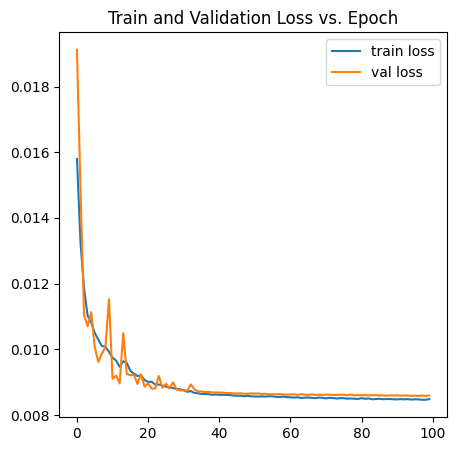

In [88]:
figure = plt.figure(figsize=(5,5))
plt.plot(log['train_losses'], label='train loss')
plt.plot(log['val_losses'], label='val loss')
plt.title('Train and Validation Loss vs. Epoch')
plt.legend()
plt.show()

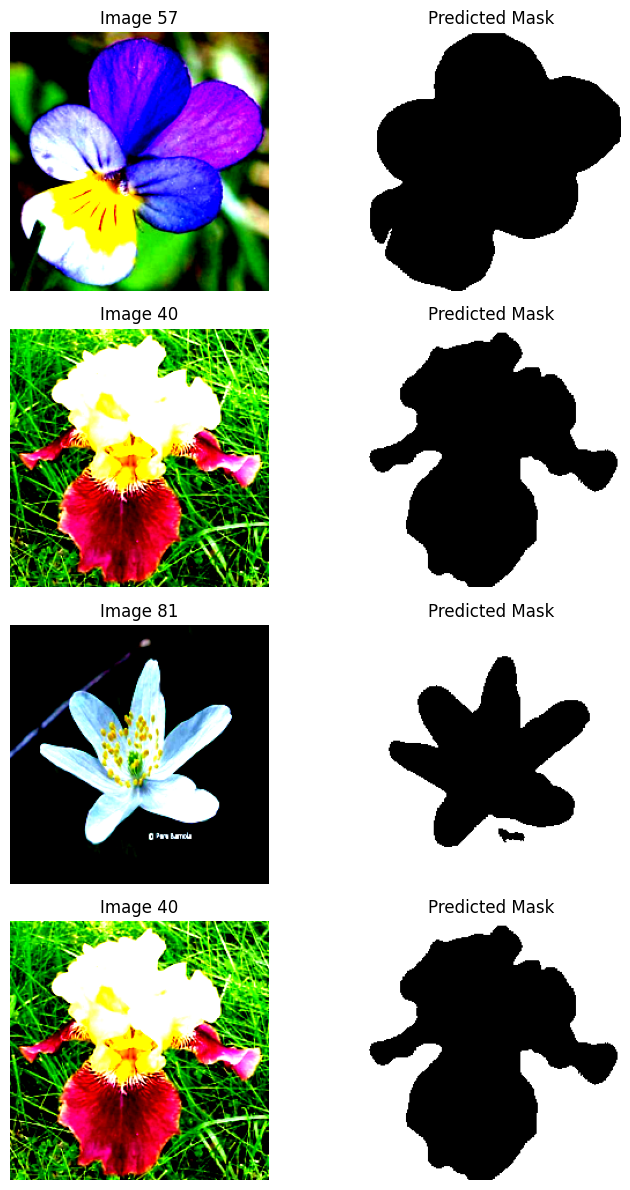

In [232]:
plot_segmentation(segmentation_model, seg_test, device)

### Processing Original Flowers Data through Segmentation Model to Isolate Flowers

Isolating flowers by using segmentation to convert background into uniform color.

In [31]:
def predict_mask(model, image, device):
    """
    Function to predict the mask of a singular image. Usage as a helper function 
    in processing dataset images to isolate flowers.

    Parameters:
    model: U-net segmentation model
    image: image to predict mask of
    device: cuda or cpu

    Returns:
    predicted mask
    """
    
    model.eval()
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        output = output.cpu()
        mask = (output<0.3).float().squeeze(0).numpy()

    return mask

In [32]:
def apply_segmask(image, mask, background_color=(0,0,0)):
    mask = np.squeeze(mask)
    mask = mask.astype(np.uint8)
    image = np.transpose(image, (1, 2, 0))
    
    background = np.ones_like(image, dtype=np.uint8) * np.array(background_color, dtype=np.uint8)

    result = np.where(mask[:, :, None] == 1, image, background)
    return result

### Some Isolation Data Visualization

In [246]:
idx = torch.randint(len(seg_test), size=(1,)).item()
img, mask = seg_test[idx]

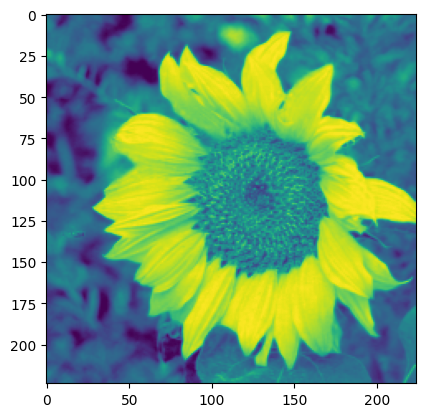

In [247]:
plt.imshow(img[0])

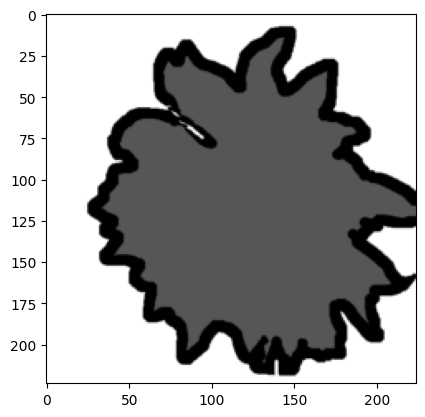

In [248]:
plt.imshow(mask[0], cmap='gray')

In [249]:
bin_mask = predict_mask(segmentation_model, img, device)

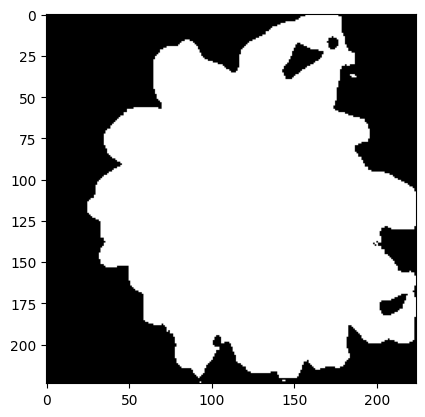

In [250]:
plt.imshow(bin_mask[0], cmap='gray')

In [251]:
new_image = apply_segmask(img, bin_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2489083].


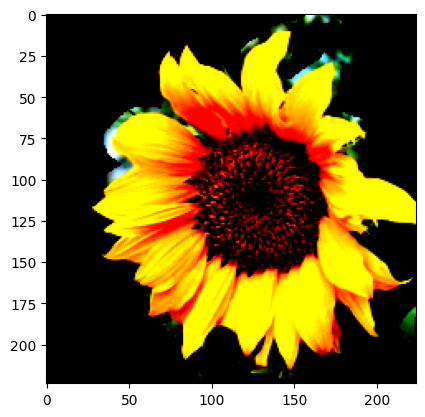

In [252]:
plt.imshow(new_image)

In [167]:
def process_dataset(csv_path, datadir, outputdir, model, new_csv_path, device='cuda'):
    df = pd.read_csv(csv_path)
    os.makedirs(outputdir, exist_ok=True)
    new_images = []

    def unnormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        return tensor * std[:, None, None] + mean[:, None, None]

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        file_name = row['filename']
        label = row['label']

        image_path = os.path.join(datadir, file_name)

        image = Image.open(image_path).convert("RGB")
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        image_tensor = transform(image)
        image_tensor = image_tensor.to(device)

        mask = predict_mask(model, image_tensor, device)

        image_tensor = image_tensor.cpu()
        image_tensor = unnormalize(image_tensor)  # Undo normalization
        image_tensor = image_tensor.clip(0,1)  # Ensure values are in [0, 1]
        
        new_image_tensor = image_tensor * mask
        
        new_filename = file_name.replace('.jpg', '_isolated.jpg')
        output_path = os.path.join(outputdir, new_filename)

        new_image = transforms.functional.to_pil_image(new_image_tensor.cpu())
        new_image.save(output_path)

        new_images.append(new_filename)

    updated_df = df.copy()
    updated_df['filename'] = new_images

    updated_df.to_csv(new_csv_path, index=False)

In [54]:
outputdir = './data/isolated_flowers/'
process_dataset('./data/test.csv', datadir, outputdir, segmentation_model, './data/iso_test.csv')
process_dataset('./data/validation.csv', datadir, outputdir, segmentation_model, './data/iso_validation.csv')
process_dataset('./data/train.csv', datadir, outputdir, segmentation_model, './data/iso_train.csv')

/tmp/ipykernel_10573/509050422.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)[00:00<?, ?it/s]
  new_image_tensor = image_tensor * mask

/tmp/ipykernel_10573/509050422.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_image_tensor = image_tensor * mask

/tmp/ipykernel_10573/509050422.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_image_tensor = image_tensor * mask

00%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1088/1088 [00:16<00:00, 65.62it/s]

In [72]:
iso_flower_train = FlowersDataset(annotations_file='./data/iso_train.csv', img_dir=outputdir, transform=transform)
iso_flower_val = FlowersDataset(annotations_file='./data/iso_validation.csv', img_dir=outputdir, transform=transform)
iso_flower_test = FlowersDataset(annotations_file='./data/iso_test.csv', img_dir=outputdir, transform=transform)
iso_flower_test[0][0].shape

torch.Size([3, 224, 224])

# Classification Model Training & Evaluation

#### Helper Functions

In [105]:
# Helper function to train each of the models that we will create
# takes
def train_model(model, epochs, train_set, val_set, batch_size, best_model_name, device, lr=0.01):
    """
    Helper function to train each of the three models that we will create
    
    Parameters:
        model: PyTorch model that will be trained
        epochs: number of epochs that we will train our model for, # of passes through the data
        train_set: the training set we will use
        val_set: the validation set we will use
        batch_size: size of our mini-batches for our dataloaders
        best_model_name: name of our best model we will save
        lr: learning rate for our optimizer
    
    Returns:
        log: dictionary of train losses, val losses, and val accuracies
    
    """
    print('Using:',device)
    log = defaultdict(list)
    
    #variable for the minimum validation loss we saw to save the best model parameters from our training
    min_val_loss = float('inf')
    
    #Create train_loader and val_loader DataLoaders that will help us work through batches in our training, validation,
    # and testing. The DataLoader is used from torch as a way to get mini-batches of size batch_size
    # We shuffle the data in training to promote randomnness but don't do so for validation or testing
    # drop_last drops the last batch from anything if its size is less than our initial batch_size
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
    
    # our optimizer, using Adam from the torch optimizer class
    # where we are optimizing our models parameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Setting up our loss function as Cross Entropy Loss
    criterion = nn.CrossEntropyLoss()
    
   
    pbar = tqdm(range(epochs))
    epochs_no_improve = 0
    
    for epoch in pbar:
        #PyTorch requires we set our model in train mode when we are training the model
        model.train()
        
        #vars to keep track of losses and total correct
        train_loss = 0
        correct = 0
        total = 0
        val_total = 0
        
        # doing our steps through the dataset through the train_loader
        # according to our batch sizes, grabbing the image tensor and the label in each iteration
        for images, labels in train_loader:
            # Reset the gradients of all the optimized Tensors to 0 for each iteration to prevent
            # incorrect calculations as gradients from previous iterations accumulate by default
            optimizer.zero_grad()
            labels = labels.long()
            images, labels = images.to(device), labels.to(device)
            #Run our images tensors through the model to receive the outputs of the class probabilities
            outputs = model(images)
            
            #Grabbing the loss according to the labels through our Binary Cross Entropy Loss criterion
            loss = criterion(outputs.squeeze(), labels.squeeze())
            
            # accumuluating the total train loss for each iteration and the total # of samples we trained on
            # to calculate the average
            train_loss += loss.item()
            total += labels.size(0)
            
            # Conduct backpropogation to calculate the gradient of the loss function dLoss/dx for every
            # parameter x, which is then used to update the gradient for every parameter x
            # gradient_x += dLoss/dx
            loss.backward()
            
            # optimizer.step() will now update the parameter x according to the new gradient from loss.backward()
            # and the learning rate.
            # x += -lr * gradient_x
            optimizer.step()
        
        #grab the train loss for this epoch and append it to the log
        train_loss /= total
        log['train_losses'].append(train_loss)
        
        #set the model in evaluation mode in order to test this pass through the data according to the val set
        #setting the model for inference
        model.eval()
        val_loss = 0
        
        # Using torch.no_grad() is useful for inference to reduce the computational cost because we will
        # not be calling tensor.backwards() as we are not updating any gradients
        with torch.no_grad():
            # doing our steps through the dataset through the val_loader
            # according to our batch sizes, grabbing the image tensor and the label in each iteration
            for images, labels in val_loader:
                
                labels = labels.long()
                images, labels = images.to(device), labels.to(device)
                
                #Run our images tensors through the model to receive the outputs of the class probabilities
                outputs = model(images)
                
                #Grabbing the loss according to the labels through our Binary Cross Entropy Loss criterion
                loss = criterion(outputs.squeeze(), labels.squeeze())
                
                #Accumuluating the validation loss for this pass through this batch of the validation data
                val_loss += loss.item()
                _,predicted = torch.max(outputs, dim=1)
                #Grabbing the number of correct predictions we have had for this batch of data
                correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        #Calculating the average validation loss and validation accuracy for this epoch and appending to log
        val_loss /= val_total
        val_acc = correct / val_total
        log['val_losses'].append(val_loss)
        log['val_accuracies'].append(val_acc)

        # Check to see if this epochs validation loss is less than the min to save the best model parameters
        # according to the validation loss
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), f'{best_model_name}.pt')
        
        pbar.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.5f}")
    return log

In [95]:
def evaluation(model, batch_size, test_set):
    """
    Function to conduct inference and calculate accuracy of our model according to our mnist test set of data.
    
    Parameters:
        model: model to conduct inference on
        batch_size: batch_size of our DataLoader for our test data, same as batch_size for training
        test_set: our testing data set
    
    Returns:
        accuracy: float of the accuracy of our model
    """
    # test_loader DataLoader that will help us work through batches in our inference.
    # The DataLoader is used from torch as a way to get mini-batches of size batch_size
    # We shuffle the data in training to promote randomnness but don't do so for validation or testing
    # drop_last drops the last batch from anything if its size is less than our initial batch_size
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    
    #Again, set model in eval() mode to conduct inference
    model.eval()

    #Using torch.no_grad() is useful for inference to reduce the computational cost because we will
    # not be calling tensor.backwards() as we are not updating any gradients
    with torch.no_grad():
        #vars to calculate accuracy
        correct = 0
        total = 0
        # doing our steps through the dataset through the test_loader
        # according to our batch sizes, grabbing the image tensor and the label in each iteration
        for images, labels in test_loader:
            labels = labels.long()
            images, labels = images.to(device), labels.to(device)

            #Run our images tensors through the model to receive the outputs of the class probabilities
            outputs = model(images)
            _,predicted = torch.max(outputs, dim=1)
            #Grabbing the number of correct predictions we have had for this batch of data
            correct += (predicted == labels).sum().item()
            # the total # of samples we trained on
            # to calculate the average
            total += labels.size(0)
    #Calculating accuracy
    accuracy = correct / total
            
    return accuracy

In [102]:
def plot_flowers(model, test_set, device):
    """
    Plot 3 random animals from the test set and title them with their output predicted from our model
    
    Parameters:
        model: model to run 3 samples of our test data through to receive the prediction
        test_set: type of test data we are using, dogcat_test
    """
    #setting up our plt figure and our subplots
    fig, axes = plt.subplots(3, 1, figsize=(6, 6))
    axes = axes.flatten()
    #setting the model in eval mode
    model.eval()
    model.to(device)
    for i in range(3):
        #grabbing a random index according to the length of our test dataset
        idx = torch.randint(len(test_set), size=(1,)).item()
        #grabbing the corresponding sample image Tensor and label from the test dataset
        img, label = test_set[idx]
        img = img.to(device)
        #Setting in no_grad() as we are not computing any backwards() and updating the gradients, as we
        #are purely in inference mode
        with torch.no_grad(): 
            #grabbing the output from our model, we do img.unsqueeze(0) to add a batch_dimension so we don't
            #get any shape errors
            output = model(img.unsqueeze(0))
        #showing the sample image by turning it back to the cpu and showing a (224,224) image
        img = img.cpu()
        axes[i].imshow(img[0])
        #Label and Prediction
        axes[i].set_title(f'Label: {label}, Prediction: {(torch.argmax(output, dim=1)).item()}', fontsize=8)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## With Segmentation Images

In [70]:
# following torch implementation found in docs to set the pre-trained weights to the weights on the model trained on ImageNet-1K
weights = models.ResNet50_Weights.DEFAULT
#Getting the model
classification_model = models.resnet50(weights=weights)



In [71]:
classification_model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1000),
    nn.Linear(in_features=1000, out_features=17)
)

In [106]:
best_classification_model = 'best-classification-parameters'
classification_model.to(device)
classification_log = train_model(classification_model, 100, iso_flower_train, iso_flower_val, 64, best_classification_model, device, lr=0.00001)

with open('classification_log.pkl', 'wb') as f:
    pickle.dump(classification_log, f)

Using: cuda



poch 100/100, Loss: 0.00000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:10<00:00, 10.90s/it]

In [107]:
print(f'Accuracy: {evaluation(classification_model, 64, iso_flower_test):.3f}')

Accuracy: 0.961


In [119]:
print(f'Accuracy: {evaluation(classification_model, 64, flower_test):.3f}')

Accuracy: 0.891


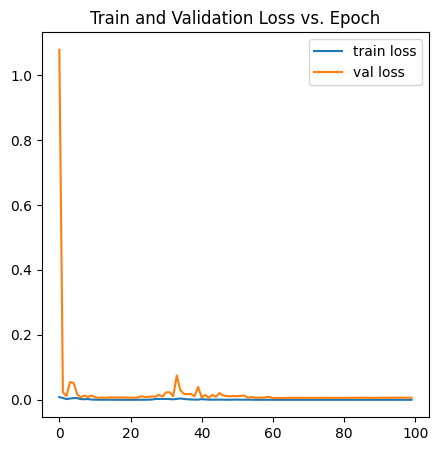

In [108]:
figure = plt.figure(figsize=(5,5))
plt.plot(classification_log['train_losses'], label='train loss')
plt.plot(classification_log['val_losses'], label='val loss')
plt.title('Train and Validation Loss vs. Epoch')
plt.legend()
plt.show()

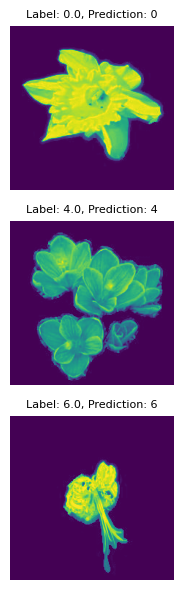

In [109]:
plot_flowers(classification_model, iso_flower_test, device)

## With Original Images --> Just for Comparison and Inference

I will be using the classification model trained on the segmented images as the model for GradCAM inference.

In [110]:
# following torch implementation found in docs to set the pre-trained weights to the weights on the model trained on ImageNet-1K
weights = models.ResNet50_Weights.DEFAULT
#Getting the model
orig_classification_model = models.resnet50(weights=weights)

orig_classification_model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1000),
    nn.Linear(in_features=1000, out_features=17)
)

for param in orig_classification_model.parameters():
    param.requires_grad = True

best_orig_classification_model = 'best-orig-classification-parameters'
orig_classification_model.to(device)
orig_classification_log = train_model(orig_classification_model, 100, flower_train, flower_val, 64, best_orig_classification_model, device, lr=0.0001)

with open('orig_classification_log.pkl', 'wb') as f:
    pickle.dump(orig_classification_log, f)

Using: cuda



poch 100/100, Loss: 0.00380: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:02<00:00, 11.42s/it]

In [117]:
print(f'Accuracy: {evaluation(orig_classification_model, 64, flower_test):.3f}')

Accuracy: 0.820


In [118]:
print(f'Accuracy: {evaluation(orig_classification_model, 64, iso_flower_test):.3f}')

Accuracy: 0.789


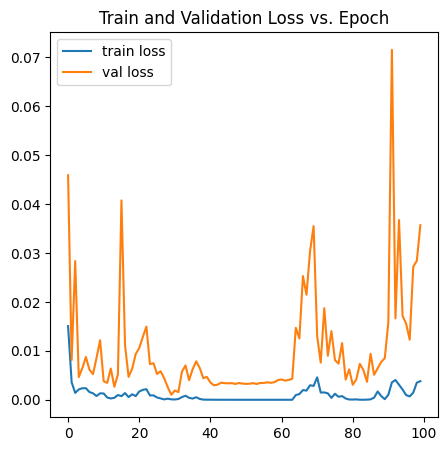

In [113]:
figure = plt.figure(figsize=(5,5))
plt.plot(orig_classification_log['train_losses'], label='train loss')
plt.plot(orig_classification_log['val_losses'], label='val loss')
plt.title('Train and Validation Loss vs. Epoch')
plt.legend()
plt.show()

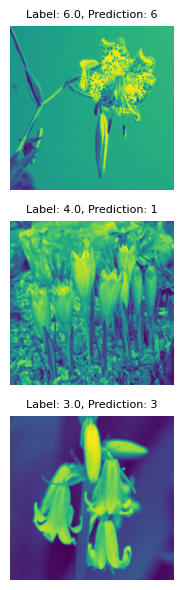

In [114]:
plot_flowers(orig_classification_model, flower_test, device)

Initial look, the segmentation of the flowers improved the accuracy by a difference of +7% for the original flowers test set, and +17% for the segmented flowers test set, suggesting overall better performance but also that the segmented-trained classification model is very suited towards the segmented flowers and has lower performance by -7% for original flower images.

# GradCAM

In [111]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [137]:
gradcam_model = models.resnet50(weights=None)

gradcam_model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1000),
    nn.Linear(in_features=1000, out_features=17)
)
gradcam_model.load_state_dict(torch.load('./best-classification-parameters.pt', weights_only=True))
gradcam_model.to(device)

gradcam_model.eval()
target_layers = [gradcam_model.layer4[-1]]

grad_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [227]:
def apply_gradcam(image_path, model, target_layers, class_index=None, device='cuda'):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    in_tensor = grad_transform(image).unsqueeze(0).to(device)

    cam = GradCAM(model=model, target_layers=target_layers)

    if class_index is None:
        with torch.no_grad():
            outputs = model(in_tensor)
            class_index = torch.argmax(outputs).item()

    targets = [ClassifierOutputTarget(class_index)]

    grayscale_cam = cam(input_tensor=in_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    grayscale_cam_resized = cv2.resize(grayscale_cam, original_size)
    
    rgb_img = np.array(image) / 255.0  
    visualization = show_cam_on_image(rgb_img, grayscale_cam_resized, use_rgb=True)

    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.title(f"Grad-CAM for Label: {class_index}")
    plt.imshow(visualization)
    plt.show()

In [231]:
def visualize_gradcam(dataset, model, target_layers, device='cuda'):
    """
    Visualize 10 images from a dataset with their Grad-CAM heatmap and class index as the title,
    using the apply_gradcam helper function.

    Args:
        dataset: PyTorch Dataset object containing the images and labels.
        model: The trained PyTorch model.
        target_layers: Target layers for Grad-CAM.
        device (str): Device to run inference ('cuda' or 'cpu').

    Returns:
        None
    """
    model.eval()

    indices = torch.randperm(len(dataset))[:10]

    plt.figure(figsize=(10, 20))
    for i, idx in enumerate(indices):
        idx = int(idx)


        img_path = os.path.join(dataset.img_dir, dataset.img_labels.iloc[idx, 0])  # Image path
        label = int(dataset.img_labels.iloc[idx, 1])

        apply_gradcam(img_path, model, target_layers, class_index=label, device=device)

    plt.tight_layout()
    plt.show()

<Figure size 1000x2000 with 0 Axes>

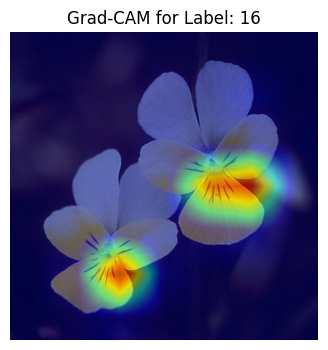

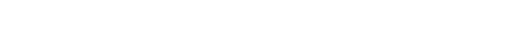

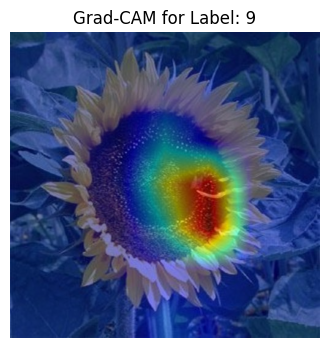

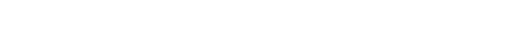

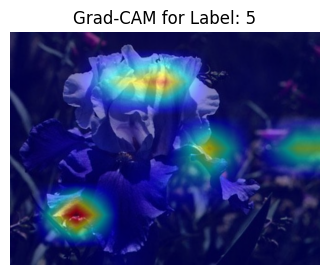

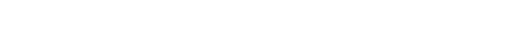

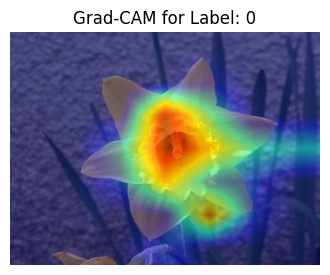

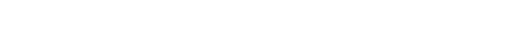

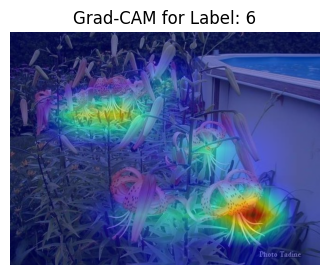

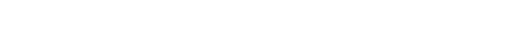

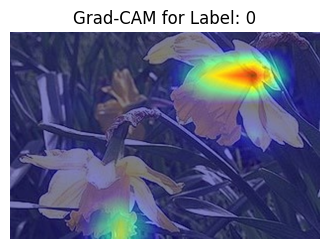

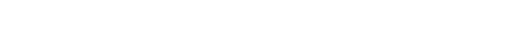

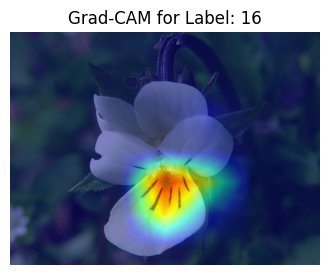

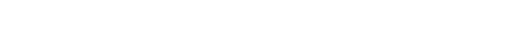

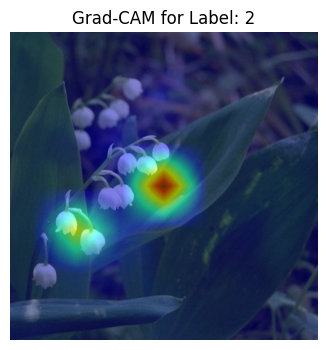

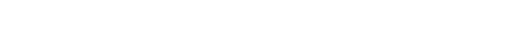

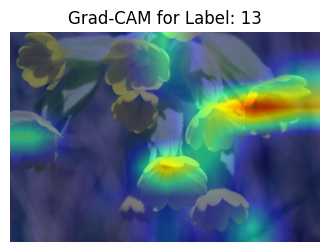

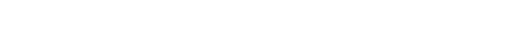

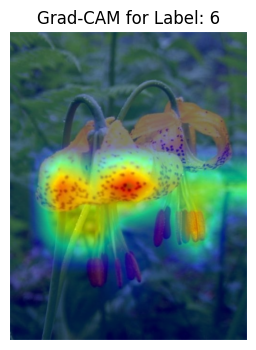

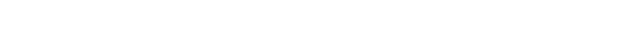

In [230]:
visualize_gradcam(flower_test, gradcam_model, target_layers)

In [256]:
gradcam_model_orig = models.resnet50(weights=None)

gradcam_model_orig.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1000),
    nn.Linear(in_features=1000, out_features=17)
)
gradcam_model_orig.load_state_dict(torch.load('./best-orig-classification-parameters.pt', weights_only=True))
gradcam_model_orig.to(device)

target_layers = [gradcam_model_orig.layer4[-1]]

grad_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

<Figure size 1000x2000 with 0 Axes>

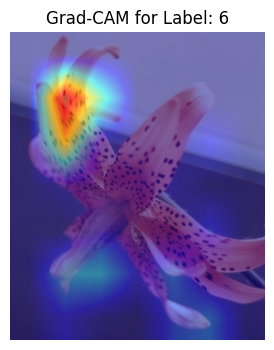

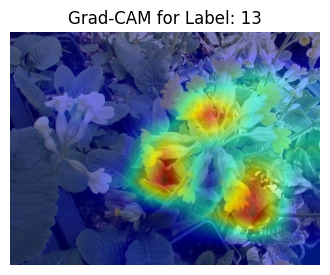

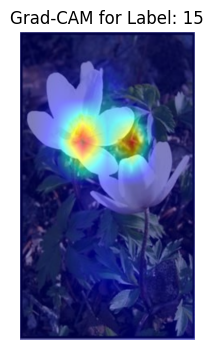

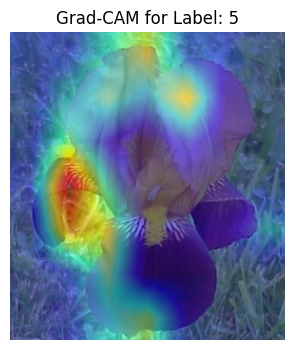

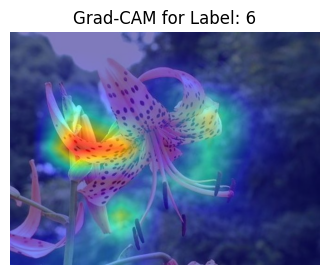

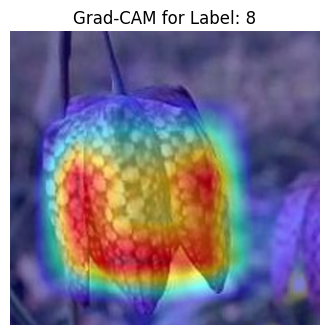

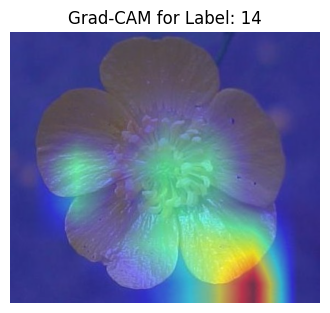

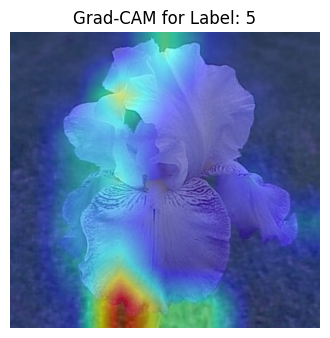

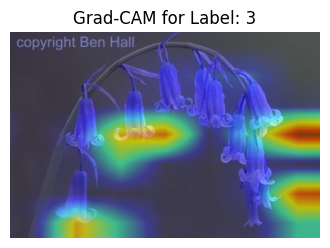

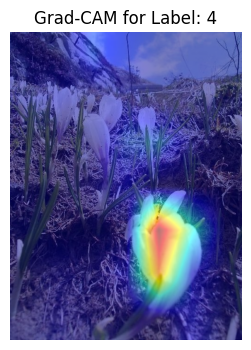

<Figure size 640x480 with 0 Axes>

In [257]:
visualize_gradcam(flower_test, gradcam_model_orig, target_layers)